# Homework 2

The homework consists in theoretical questions and coding exercises.

- Code must be commented. If you use code you found online, you have to add the link to the source you used. There is no penalty for using outside sources as long as you convince us you understand the code.
- For detailed discussion on code of honour for this course, please see the Practice 1 recording if you missed the practice session.

**To pass the homework you need to attempt to do all tasks. If we see that you misunderstand some concept, you may receive personal feedback and you can have a chance to resubmit your homework.**
**Please treat these homeworks as learning opportunities to support your study! Instead of copy-pasting solution, attempt to do it yourself and rather learn from feedback**

\*Once completed zip the entire directory containing this exercise and upload it to Moodle.

For background reading see http://cs231n.github.io/classification/.


## k-Nearest Neighbor (kNN) exercise

In this assignment you will

- understand the basic Image Classification pipeline and the data-driven approach (train/predict stages),
- understand the train/val/test splits and the use of validation data for hyperparameter tuning,
- develop proficiency in writing efficient vectorized code with numpy,
- implement and apply a k-Nearest Neighbor (kNN) classifier.

### Requirements

**Install PyTorch** by running the following command (for installation CPU only. If you have a GPU or a different set of hardware, operational system, etc, check the exact command to run for your system at the link https://pytorch.org/get-started/locally/):

```
pip install torch torchvision
```

To confirm the installation, you can check the version of PyTorch by running:

```
python -c "import torch; print(torch.__version__)"
```

### Downloading data

Download the CIFAR-10 dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and untar it to `../datasets`:

```
tar -xzvf cifar-10-python.tar.gz
```

### kNN

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated


In [27]:
"""

    Run some setup code for this notebook.

"""

import torch
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

#this is to make sure your .py changes will be automatically reloaded in jupyter'
#%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
"""

    Load CIFAR

"""


cifar10_dir = './cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# send to torch
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  torch.Size([50000, 32, 32, 3])
Training labels shape:  torch.Size([50000])
Test data shape:  torch.Size([10000, 32, 32, 3])
Test labels shape:  torch.Size([10000])


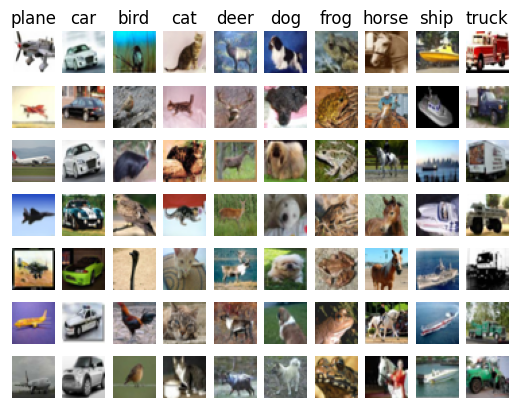

In [29]:
"""

    Visualize some examples from the dataset.
    We show a few examples of training images from each class.

"""

classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    # indices where label == y
    idxs = torch.nonzero(y_train == y, as_tuple=True)[0]

    # randomly choose samples_per_class indices
    perm = torch.randperm(len(idxs))[:samples_per_class]
    idxs = idxs[perm]

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)

        img = X_train[idx]

        # If tensor is CHW, convert to HWC
        if img.dim() == 3 and img.shape[0] in {1, 3}:
            img = img.permute(1, 2, 0)

        plt.imshow(img.cpu().numpy().astype('uint8'))
        plt.axis('off')

        if i == 0:
            plt.title(cls)

plt.show()

In [30]:
"""

    Subsample the data for more efficient code execution in this exercise

"""

num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

print( f'X_train shape: {X_train.shape}' )
print( f'y_train shape: {y_train.shape}' )
print('')
print( f'X_test shape: {X_test.shape}' )
print( f'y_test shape: {y_test.shape}' )

X_train shape: torch.Size([5000, 32, 32, 3])
y_train shape: torch.Size([5000])

X_test shape: torch.Size([500, 32, 32, 3])
y_test shape: torch.Size([500])


In [31]:
"""

Reshape the image data into rows

"""

X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)

print( f'X_train shape: {X_train.shape}' )
print( f'X_test shape: {X_test.shape}' )

X_train shape: torch.Size([5000, 3072])
X_test shape: torch.Size([500, 3072])


In [32]:
"""

    Create a kNN classifier instance.
    Remember that training a kNN classifier is a loop:
        - The Classifier simply remembers the data and does no further processing

"""

from k_nearest_neighbor import KNearestNeighbor
import torch

classifier = KNearestNeighbor()

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element $(i,j)$ is the distance between the $i$-th test and $j$-th train example.


**Task 2.1**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.


In [34]:
"""

    Open k_nearest_neighbor.py and implement compute_distances_two_loops.

"""


classifier.train(X_train, y_train)

dists = classifier.compute_distances_two_loops(X_test)
print( f'dists shape: { dists.shape }' )

# verify torch output is not zero
assert not torch.all(dists == 0), "ERROR: The function seems to not be implemented, the output is all zeros"

# verify torch output is correct
assert torch.isclose(dists[0,1], torch.tensor(4210.59603857), atol=1e-6), "ERROR: The function seems to not be correct - an answer does not match with what we got"
print("compute_distances_two_loops seems to be correct!")

dists shape: torch.Size([500, 5000])
compute_distances_two_loops seems to be correct!


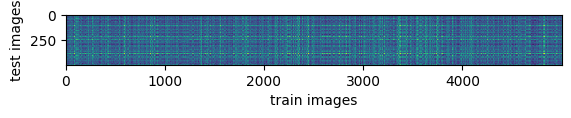

In [36]:
"""

    We can visualize the distance matrix: each row is a single test example and its distances to training examples

"""

plt.imshow(dists, interpolation='none')
plt.xlabel("train images")
plt.ylabel("test images")
plt.show()

In [38]:
import torch
torch.cuda.is_available()

True

**Task 2.2**

Observe the structured patterns in the distance matrix. Some rows or columns appear noticeably brighter.
(Note: In the default color scheme, black indicates low distances, while white indicates high distances.)

Answer the following questions:


2.2.1 If a test image is far from the training images, this would appear as a distinctly bright \_\_\_ (row or column)?


**Your answer 2.2.1**:


In [ ]:
# I would expect a test image that is far from the training images to appear as a distinctly bright row in the distance matrix. This is because each row corresponds to a test image, and if a test image is far from the training images, the distances in that row would be higher, resulting in a brighter appearance.

2.2.2. If a training image is far from the test images, this would appear as a distinctly bright \_\_\_ (row or column)?


**Your answer 2.2.2**:


In [ ]:
# I would expect a training image that is far from the test images to appear as a distinctly bright column in the distance matrix. This is because each column corresponds to a training image, and if a training image is far from the test images, the distances in that column would be higher, resulting in a brighter appearance.

**Task 2.3**

Now implement the function `predict_labels` in `k_nearest_neighbor.py` and run the code below:


In [40]:
"""

    We use k = 1 (which is Nearest Neighbor).

"""

y_test_pred = classifier.predict_labels(dists, k=1)

print( f'y_test_pred shape: {y_test_pred.shape}' )

# Compute and print the fraction of correctly predicted examples
num_correct = torch.sum( y_test_pred == y_test )
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

assert torch.isclose( torch.tensor(accuracy), torch.tensor(0.274), atol=1e-6 ), "The accuracy is not correct, there is some problem"

print("Accuracy check passed")

y_test_pred shape: torch.Size([500])
Got 137 / 500 correct => accuracy: 0.274000
Accuracy check passed


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:


In [41]:
y_test_pred = classifier.predict_labels(dists, k=5)

print( f'y_test_pred shape: { y_test_pred.shape }' )

num_correct = torch.sum( y_test_pred == y_test )
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

assert torch.isclose( torch.tensor(accuracy), torch.tensor(0.278), atol=1e-6 ), "The accuracy is not correct, there is some problem"

print("Accuracy check for larget k passed")

y_test_pred shape: torch.Size([500])
Got 139 / 500 correct => accuracy: 0.278000
Accuracy check for larget k passed


You should expect to see a slightly better performance than with `k = 1`.


**Task 2.4**

Now lets speed up distance matrix computation by using partial vectorization with one loop. Implement the function `compute_distances_one_loop` in `k_nearest_neighbor.py` and run the code below:


In [42]:
"""

    To ensure that our vectorized implementation is correct, we make sure that it
    agrees with the naive implementation.

    There are many ways to decide whether two matrices are similar; one of the simplest is the Frobenius norm.

    In case you haven't seen it before, the Frobenius norm of two matrices is the square
    root of the squared sum of differences of all elements; in other words, reshape
    the matrices into vectors and compute the Euclidean distance between them.

"""

dists_one = classifier.compute_distances_one_loop(X_test)

print( f'dists one shape: f{ dists_one.shape }' )

difference = torch.norm(dists - dists_one, p='fro')

print('Difference was: %f' % difference.item())

if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

dists one shape: ftorch.Size([500, 5000])
Difference was: 0.000000
Good! The distance matrices are the same


**Task 2.5**

Now implement the fully vectorized version inside `compute_distances_no_loops` in `k_nearest_neighbor.py` and run the code


In [43]:
dists_two = classifier.compute_distances_no_loops(X_test)

print( f'dists two shape: { dists_one.shape }' )

# check that the distance matrix agrees with the one we computed before:

difference = torch.norm( dists - dists_two, p='fro' )
print( f'Difference was: { difference.item() }' )

# due to the limitation in torch that is by default set to float32, we will use the maximum single-cell difference as a more stringent check
max_diff = torch.max(torch.abs(dists - dists_two))
print(f"Maximum single-cell difference: {max_diff}")

# using torch built in function
dists_pytorch = torch.cdist(X_test, X_train, p=2)
difference_pytorch = torch.norm(dists - dists_pytorch, p='fro')
print(f"Difference with PyTorch's cdist: {difference_pytorch.item()}")

if max_diff < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

dists two shape: torch.Size([500, 5000])
Difference was: 0.20319877290802632
Maximum single-cell difference: 0.00048826752572495025
Difference with PyTorch's cdist: 0.20319877290802632
Good! The distance matrices are the same


In [44]:
"""

    Let's compare how fast the implementations are.

    You should see significantly faster performance with the fully vectorized implementation.

"""

def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 153.101762 seconds
One loop version took 13.804445 seconds
No loop version took 0.124035 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value `k = 5` arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

**Task 2.6**


In [45]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the torch.chunk function.                                #
################################################################################


X_train_folds = torch.chunk(X_train, num_folds)
y_train_folds = torch.chunk(y_train, num_folds)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

print( f'X_train_folds: { [ x.shape for x in X_train_folds ] }' )
print( f'y_train_folds: { [ y.shape for y in y_train_folds ] }' )

assert torch.stack(X_train_folds).shape == (5, 1000, 3072), "the shape of folds is not correct"
print("Folds look good!")

X_train_folds: [torch.Size([1000, 3072]), torch.Size([1000, 3072]), torch.Size([1000, 3072]), torch.Size([1000, 3072]), torch.Size([1000, 3072])]
y_train_folds: [torch.Size([1000]), torch.Size([1000]), torch.Size([1000]), torch.Size([1000]), torch.Size([1000])]
Folds look good!


**Task 2.7**


In [46]:
"""

    A dictionary holding the accuracies for different values of k that we find
    when running cross-validation. After running cross-validation,
    k_to_accuracies[k] should be a list of length num_folds giving the different
    accuracy values that we found when using that value of k.

"""

k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################


for k in k_choices:
    k_to_accuracies[k] = []
    for fold in range(num_folds):
        X_train_fold = torch.cat([X_train_folds[i] for i in range(num_folds) if i != fold])
        y_train_fold = torch.cat([y_train_folds[i] for i in range(num_folds) if i != fold])
        X_val_fold = X_train_folds[fold]
        y_val_fold = y_train_folds[fold]

        # Train the classifier on the training folds
        classifier.train(X_train_fold, y_train_fold)

        # Compute distances between the validation fold and the training folds
        dists = classifier.compute_distances_no_loops(X_val_fold)

        # Predict labels for the validation fold
        y_val_pred = classifier.predict_labels(dists, k=k)

        # Compute accuracy and store it
        num_correct = torch.sum(y_val_pred == y_val_fold)
        accuracy = float(num_correct) / len(y_val_fold)
        k_to_accuracies[k].append(accuracy)


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

# Checks for CV dictionary
assert isinstance(k_to_accuracies, dict)
assert set(k_to_accuracies.keys()) == set(k_choices), "Missing or extra k keys"

for k, vals in k_to_accuracies.items():
    assert isinstance(vals, list), f"k={k} values must be list"
    assert len(vals) == num_folds, f"k={k} must have {num_folds} fold accuracies"
    for a in vals:
        assert isinstance(a, (float, int)), f"k={k} has non-numeric accuracy"
        assert 0.0 <= float(a) <= 1.0, f"k={k} accuracy out of range [0,1]"

print("All tests passed!")

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

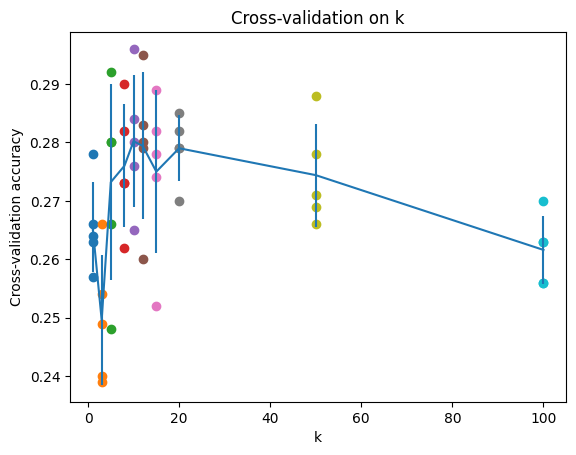

Best k: 10


In [49]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

sorted_k = sorted(k_to_accuracies.keys())

means = []
stds = []

for k in sorted_k:

    k_tensor = torch.tensor(k_to_accuracies[k])
    means.append(torch.mean(k_tensor).item())
    stds.append(torch.std(k_tensor).item())

plt.errorbar(sorted_k, means, yerr=stds)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

best_k_idx = torch.argmax(torch.tensor(means)).item()
print(f'Best k: {sorted_k[best_k_idx]}')

In [50]:
# find best k

best_k = None
best_accuracy = 0.0

for k in k_choices:
	accuracies = k_to_accuracies[k]
	avg_accuracy = sum(accuracies) / len(accuracies)
	print(f"k={k}, average accuracy={avg_accuracy:.4f}")
	if avg_accuracy > best_accuracy:
		best_accuracy = avg_accuracy
		best_k = k

print(f"Best k: {best_k} with average accuracy: {best_accuracy:.4f}")

k=1, average accuracy=0.2656
k=3, average accuracy=0.2496
k=5, average accuracy=0.2732
k=8, average accuracy=0.2760
k=10, average accuracy=0.2802
k=12, average accuracy=0.2794
k=15, average accuracy=0.2750
k=20, average accuracy=0.2790
k=50, average accuracy=0.2744
k=100, average accuracy=0.2616
Best k: 10 with average accuracy: 0.2802


In [51]:
"""

    Based on the cross-validation results above, choose the best value for k,
    retrain the classifier using all the training data, and test it on the test
    data. You should be able to get above 28% accuracy on the test data.

"""

best_k = 10 # 10 was the best for me

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = torch.sum(y_test_pred == y_test).item()
num_test = y_test.shape[0]
accuracy = float(num_correct) / num_test

print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
